# Triplet Loss Representation

In [1]:
# STD MODULE
import os
import sys
import numpy as np
import cv2
import pandas as pd

# TORCH MODULE
import torch
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils

# PYTVISION MODULE
from pytvision.transforms import transforms as mtrans
from pytvision import visualization as view

# LOCAL MODULE
sys.path.append('../')
from torchlib.datasets.factory  import FactoryDataset 
from torchlib.datasets import Dataset, SecuencialSamplesDataset, TripletsDataset
from torchlib.tripletneuralnet import TripletNeuralNet
from misc import get_transforms_aug, get_transforms_det

import matplotlib.pyplot as plt
%matplotlib inline

sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)


In [2]:

pathname = os.path.expanduser( '~/.datasets' )
name_dataset=FactoryDataset.cifar10
projectmanifold='../out/tripletruns'
no_cuda=False
seed=1
gpu=1
batch_size=60
workers=60
num_input_channels=3

print(pathname)
print(name_dataset)


/home/fernandez/.datasets
cifar10


In [3]:
!ls ../out/tripletruns/

exp_triplet_embalexnet_hinge_adam_cifar10_emb32_001
exp_triplet_embresnet18_hinge_adam_cifar10_emb32_001
exp_triplet_embsimplenet_hinge_adam_cifar10_emb32_001
exp_triplet_embsimplenet_hinge_adam_ferp_emb16_001
exp_triplet_embsimplenet_hinge_adam_ferp_emb32_001
exp_triplet_embsimplenet_hinge_adam_mnist_001


In [4]:
name='exp_triplet_embresnet18_hinge_adam_cifar10_emb32_001'
model= 'model_best.pth.tar'  #'chk001025.pth.tar'

project = os.path.join(projectmanifold, name)
pathmodels = os.path.join(project,'models',model)

print(project)
print(pathmodels)

../out/tripletruns/exp_triplet_embresnet18_hinge_adam_cifar10_emb32_001
../out/tripletruns/exp_triplet_embresnet18_hinge_adam_cifar10_emb32_001/models/model_best.pth.tar


# Load model 

In [5]:
# neuralnet
network = TripletNeuralNet(
    patchproject=project,
    nameproject=name,
    no_cuda=no_cuda,
    seed=seed,
    gpu=gpu
    )

cudnn.benchmark = True

# load model
if network.load( pathmodels ) is not True:
    assert(False)

=> loading checkpoint '../out/tripletruns/exp_triplet_embresnet18_hinge_adam_cifar10_emb32_001/models/model_best.pth.tar'
=> loaded checkpoint for embresnet18 arch!


# Load data

In [21]:
# validation dataset
subset = FactoryDataset.validation

data = Dataset(
    data=FactoryDataset.factory(
        pathname=pathname, 
        name=name_dataset, 
        subset=subset, 
        download=False ),
    num_channels=num_input_channels,
    transform=get_transforms_det( network.size_input )
    )
dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=workers )


print(subset)
print(data.classes)
print( len(data) )
print(len(dataloader))


val
[0 1 2 3 4 5 6 7 8 9]
10000
167


In [22]:
# representation data
Xemb, Y = network.representation( dataloader )
print('DONE!!')

100%|██████████| 167/167 [00:12<00:00, 13.41it/s]

DONE!!


In [23]:
# save data representation
reppathname = os.path.join( project, 'rep_{}_{}.csv'.format(subset, name) )
df = pd.DataFrame( np.concatenate((Xemb,Y),axis=1) )
df.to_csv( reppathname , index=False, encoding='utf-8')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.076488,0.387424,-0.194521,-0.244766,0.021231,0.494868,-0.122231,0.197866,0.031626,0.251392,...,-0.127007,-0.105847,0.005892,-0.173899,-0.178808,0.088070,0.125191,0.340884,0.192704,3.0
1,-0.052818,-0.224596,0.189349,0.205358,-0.033222,-0.008094,-0.159580,-0.005727,-0.086048,-0.185601,...,-0.470077,0.541333,-0.069554,-0.025425,0.055921,0.208491,-0.073936,-0.148572,0.133032,8.0
2,-0.043893,-0.195371,0.178308,0.322563,-0.089660,-0.194577,-0.051482,-0.059118,-0.170888,-0.141488,...,-0.370088,0.603976,-0.061169,-0.025919,0.044545,0.181539,-0.081590,-0.036437,0.215728,8.0
3,0.349173,-0.182827,0.178239,-0.012094,-0.012638,0.195603,0.124735,0.015807,-0.180040,-0.126290,...,-0.204807,0.020424,0.127469,0.131794,0.132461,-0.086634,0.146431,0.173097,0.123411,0.0
4,0.018887,0.370012,0.207882,-0.071523,0.102851,0.155319,0.222957,-0.206292,-0.130782,-0.153631,...,0.113005,-0.512385,-0.178946,-0.142845,0.022988,0.166375,-0.133047,0.151519,-0.003537,6.0


# Representation 

In [11]:
data_emb = pd.read_csv( reppathname )
data_emb = data_emb.as_matrix()
Xo = data_emb[:,:-1] 
Yo = data_emb[:,-1] 

n=40
indexs=[]
cs = np.unique(Yo)
for i,c in enumerate(cs):
    index =  np.array( np.where(Yo==int(c))[0] )
    indexs.append( index[:n] )
#     if i==10: 
#         break
    
indexs = np.array(indexs).flatten()
Xo = Xo[indexs,:]
Yo = Yo[indexs]

print(Xo.shape)
print(Yo.shape)
print( len(np.unique(Yo)) )

(400, 16)
(400,)
10


### TSNE representation

In [24]:
from sklearn.manifold import TSNE
cmap = plt.get_cmap('jet_r')

tsnpathname = os.path.join( project, 'tsn_{}_{}.csv'.format( subset, name ) )

data_emb = pd.read_csv( reppathname )
data_emb = data_emb.as_matrix()
Xo = data_emb[:,:-1]
Yo = data_emb[:,-1]

Xt = TSNE(n_components=2, init='pca', 
    random_state=0, perplexity=30).fit_transform(Xo)

# save
XY = np.concatenate((Xt,Yo[:, np.newaxis]),axis=1)
df = pd.DataFrame( XY )
df.to_csv( tsnpathname , index=False, encoding='utf-8')

print('tsne calculte done')


tsne calculte done


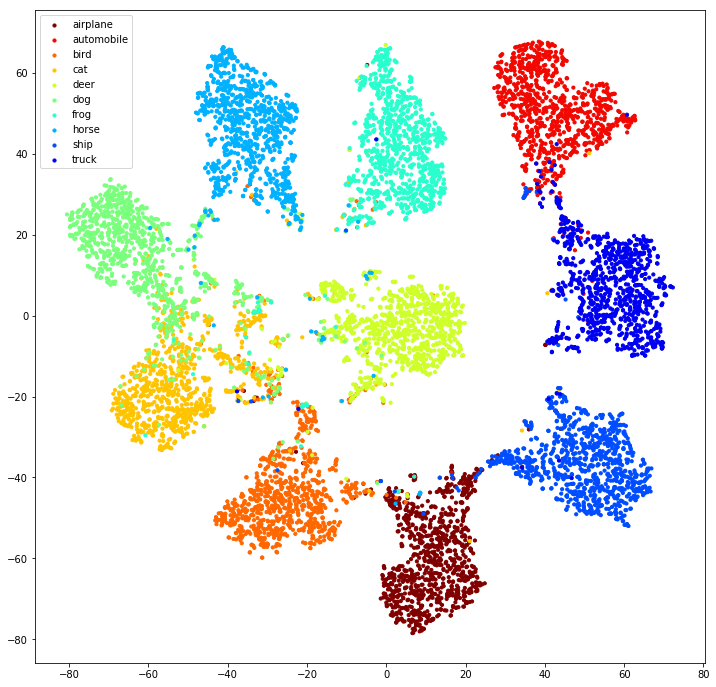

In [25]:
#show
plt.figure( figsize=(12,12) )
#plt.scatter(Xt[:,0], Xt[:,1], s=(10,10), marker='o', c=Yo);
n = len(np.unique(Yo))
for i in range( n ):
    index = Yo==i
    color = cmap(float(i)/n) 
    plt.scatter(Xt[index,0], Xt[index,1], s=(10,10), marker='o', color=color, label='{}'.format( dataloader.dataset.data.classes[i] ) );

plt.legend()
plt.savefig( os.path.join( project, 'tsn_{}_{}.png'.format( subset, name ) ) )
plt.show()

10000


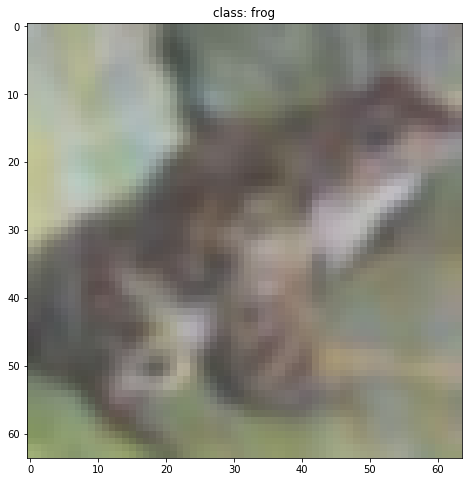

In [26]:

size_input=64
data = Dataset(
    data=FactoryDataset.factory(
        pathname=pathname, 
        name=name_dataset, 
        subset=FactoryDataset.validation, 
        download=False ),
    num_channels=num_input_channels,
    transform=mtrans.ToResize( (size_input, size_input), resize_mode='square', padding_mode=cv2.BORDER_CONSTANT ) 
    )

n = len(data)
#img, label = data[ np.random.randint(n) ]
sample = data[ np.random.randint(n) ]
img, label = sample['image'], sample['label']
label=np.argmax(label)
classe = data.data.classes[label]

#print(img)
#img = np.array(img)
#print(img.shape, np.max(img) )

print(n)
plt.figure( figsize=(8,8))
plt.imshow( img )
plt.title('class: {}'.format(classe) )
plt.show()



In [14]:
import scipy.misc
import cv2

def drawmanifold( images, x, y, S=2000, s=50, Ntake = 100, freq_print=100, bgblack=True ):
    '''
    drawmanifold
    S = 2000 # size of full embedding image
    s = 50 # size of every single image   
    Ntake = 200 #count of the object
    
    #Example    
    Mf = drawmanifold(data, Xt)
    plt.figure( figsize=(12,12) )
    plt.imshow(Mf)
    plt.show()
    
    '''
    
    #normalization 
    x = x - np.min(x)
    x = x / np.max(x)
    
    n = len(np.unique(y))
    cmap = plt.get_cmap('jet_r')    
    
    if bgblack: 
        G = np.zeros( (S, S, 3), dtype='uint8')
    else: 
        G = np.ones( (S, S, 3), dtype='uint8')*255
    
    for i in range(Ntake):

        if (i-1)%freq_print == 0:
            print('{}/{}...\n'.format(i, Ntake)  )

        # location
        a = np.ceil(x[i, 0] * (S-s))
        b = np.ceil(x[i, 1] * (S-s))
        
        a = int(a - (a)%s) 
        b = int(b - (b)%s) 

        #if G[a,b,1] != 0:
        #    continue # spot already filled
        
        I = images[i]['image']; 
        
        imshape = I.shape;
        Imask = np.ones((imshape[0]+11,imshape[1]+11))
        
        color = cmap(float(y[i])/n)
        #color = colors[ int(y[i]) ]
        
        Ir = Imask*color[0]*255
        Ig = Imask*color[1]*255
        Ib = Imask*color[2]*255
                
        Ir[5:-6,5:-6] = I[:,:,0]
        Ig[5:-6,5:-6] = I[:,:,1]
        Ib[5:-6,5:-6] = I[:,:,2]
        
        Ir = Ir[:,:, np.newaxis ]; 
        Ig = Ig[:,:, np.newaxis ]; 
        Ib = Ib[:,:, np.newaxis ]; 
        Irgb = np.concatenate((Ir,Ig,Ib), axis=2 )         
        
        Irgb = scipy.misc.imresize(Irgb, (s,s), interp='bilinear' ) 
        cv2.putText(Irgb, 'c{}'.format( int(y[i]) ) ,(10,s-10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0,0,0), 1, cv2.LINE_AA)
        
        G[a:a+s, b:b+s, :] = Irgb;
        
                
#         if len(I.shape)==2: I = I[:,:, np.newaxis ]
#         if I.shape[2] == 1: I = np.concatenate((I,I,I), axis=2 )   
#         I = scipy.misc.imresize(I, (s,s), interp='bilinear' )           
#         G[a:a+s, b:b+s, :] = I;
                      
    return G

1/10000...

3001/10000...

6001/10000...

9001/10000...



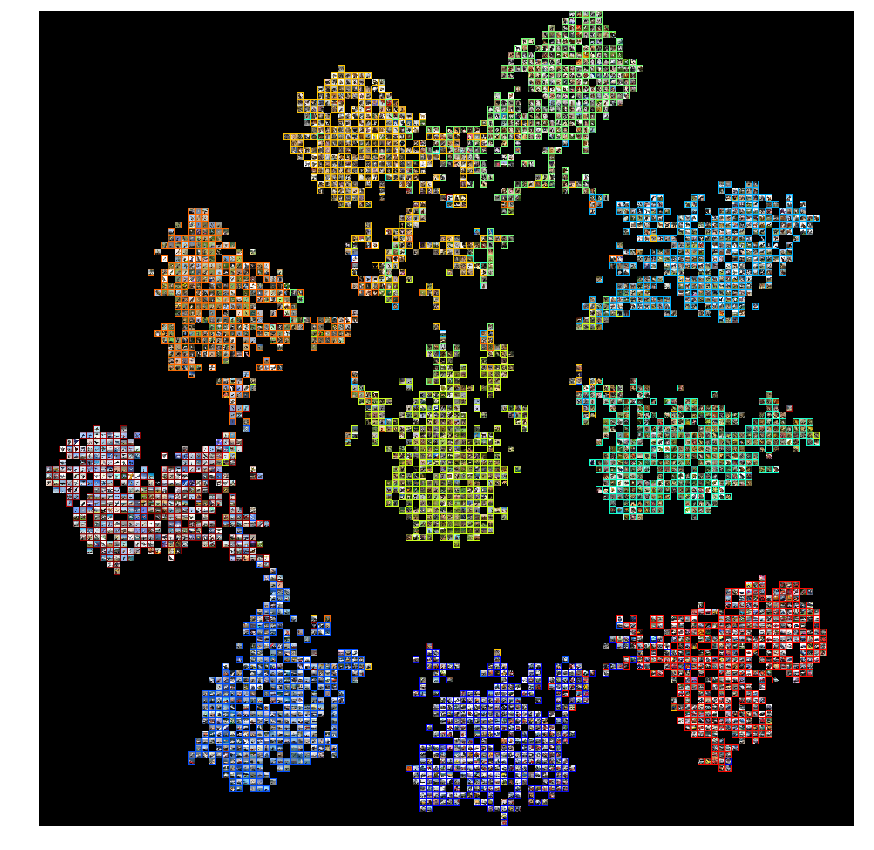

In [27]:

tsnpathname = os.path.join( project, 'tsn_{}_{}.csv'.format( subset, name ) )
tsndata = pd.read_csv( tsnpathname )
tsnXY = tsndata.as_matrix()                     
Xt = tsnXY[:,:-1]
Yt = tsnXY[:,-1]

Mf = drawmanifold(data, Xt, Yt, Ntake=len(data) , S=6000, s=50, freq_print=3000)
scipy.misc.imsave( os.path.join( project, 'tsn_img_{}_{}.jpg'.format( subset, name ) )   , Mf)

plt.figure( figsize=(12,12) )
plt.imshow(Mf)
plt.axis('off')
plt.tight_layout()
plt.ioff()
plt.show()


# Metric

In [43]:
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics


rep_trn_pathname = os.path.join( project, 'rep_{}_{}.csv'.format('train', name) )
rep_val_pathname = os.path.join( project, 'rep_{}_{}.csv'.format('val', name) )
#rep_test_pathname = os.path.join( project, 'rep_{}_{}.csv'.format('test', name) )


data_emb_train = pd.read_csv( rep_trn_pathname )
data_emb_val = pd.read_csv(  rep_val_pathname  )
#data_emb_test = pd.read_csv( rep_test_pathname )

Xtrain = data_emb_train.as_matrix()
Xval   = data_emb_val.as_matrix()
#Xtest  = reptest.as_matrix()

Xo = Xtrain[:,:-1]
Yo = Xtrain[:,-1]

k = 3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(Xo,Yo)

# Xto = Xtest[:,:-1]
# Yto = Xtest[:,-1]

Xto = Xval[:,:-1]
Yto = Xval[:,-1]

y = Yto
yhat = knn.predict(Xto)


acc = metrics.accuracy_score(y, yhat)
nmi_s = metrics.cluster.normalized_mutual_info_score(y, yhat)
mi = metrics.cluster.mutual_info_score(y, yhat)
h1 = metrics.cluster.entropy(y)
h2 = metrics.cluster.entropy(yhat)
nmi = 2*mi/(h1+h2)

print(mi, h1, h2)
    
precision = metrics.precision_score(y, yhat, average='macro')
recall = metrics.recall_score(y, yhat, average='macro')
f1_score = 2*precision*recall/(precision+recall)

print('Accuracy : %f' % acc)
print('NMI : %f vs old %f' % (nmi, nmi_s))
print('Precision : %f' % precision)
print('Recall : %f' % recall)
print('F1 score : %f' % f1_score)
print("")

2.01143949935 2.30258509299 2.30253037593
Accuracy : 0.940600
NMI : 0.873567 vs old 0.873567
Precision : 0.940698
Recall : 0.940600
F1 score : 0.940649



# Clustering

In [31]:
from sklearn.cluster import KMeans
import sklearn.metrics as metrics

rep_trn_pathname = os.path.join( project, 'rep_{}_{}.csv'.format('train', name) )
rep_val_pathname = os.path.join( project, 'rep_{}_{}.csv'.format('val', name) )
#rep_test_pathname = os.path.join( project, 'rep_{}_{}.csv'.format('test', name) )

data_emb_val = pd.read_csv( rep_val_pathname )
Xval   = data_emb_val.as_matrix()

Xto = Xval[:,:-1]
Yto = Xval[:,-1]

x = Xto
y = Yto

# initialize centroid for each cluster
n,dim = x.shape
classes = np.unique(y)
m = len(classes)
kcenter = np.zeros(shape=(m, dim), dtype=float)
for i in range(m):
    index = np.random.choice(np.where(y == classes[i])[0])
    kcenter[i,:] = x[index,:]

# pred
kmodel = KMeans(n_clusters=m, random_state=1, max_iter=3000, tol=1e-3, init=kcenter, n_init=1)
yhat = kmodel.fit_predict(x)

ars = metrics.adjusted_rand_score(y, yhat)
print(ars)


0.876993945969


In [32]:
acc = metrics.accuracy_score(y, yhat)
nmi_s = metrics.cluster.normalized_mutual_info_score(y, yhat)
mi = metrics.cluster.mutual_info_score(y, yhat)
h1 = metrics.cluster.entropy(y)
h2 = metrics.cluster.entropy(yhat)
nmi = 2*mi/(h1+h2)

print(mi, h1, h2)
    
precision = metrics.precision_score(y, yhat, average='macro') #micro
recall = metrics.recall_score(y, yhat, average='macro') #micro
f1_score = 2*precision*recall/(precision+recall)

print('Accuracy : %f' % acc)
print('NMI : %f vs old %f' % (nmi, nmi_s))
print('Precision : %f' % precision)
print('Recall : %f' % recall)
print('F1 score : %f' % f1_score)
print("")

2.01535084197 2.30258509299 2.30181522194
Accuracy : 0.941200
NMI : 0.875402 vs old 0.875402
Precision : 0.941743
Recall : 0.941200
F1 score : 0.941471



In [32]:
#metric = metrics.classification_report(y, yhat)
#print(metric)
#print("")

In [40]:
#mc = metrics.confusion_matrix(y, yhat)
#print(mc)
#print("")

In [33]:
def RecallK(embeddings, labels, nks = 4):
    '''
    Recall@K
    '''    
    accuracy = np.zeros((nks,))
    recall   = np.zeros((nks,))
    num_times = len(labels)
    
    for i in range(num_times):
        
        id_query = i
        l_query = labels[id_query]
        f_query = embeddings[id_query, :]
        
        d_query = embeddings - f_query
        d_query = np.linalg.norm(d_query, axis=1).reshape((-1))
        sort_ids = np.argsort(d_query)
        
        for k in range(nks):
            
            kneighbors = 2**k
            res_ids = sort_ids[0:kneighbors+1]
            res_labels = labels[res_ids]
        
            num_correct = np.where(res_labels == l_query)[0].shape[0] - 1        
            if num_correct > 0: 
                accuracy[k] += float(num_correct)/float(kneighbors)
                recall[k] += 1.0            
            
    accuracy = accuracy / float(num_times)
    recall = recall / float(num_times)
    return accuracy, recall

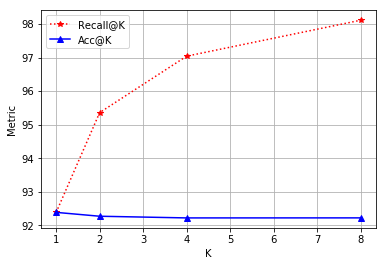

[ 0.9239  0.9536  0.9704  0.9811]
[ 0.9239     0.92275    0.92225    0.9222625]


In [34]:
from sklearn.cluster import KMeans
import sklearn.metrics as metrics

rep_trn_pathname = os.path.join( project, 'rep_{}_{}.csv'.format('train', name) )
rep_val_pathname = os.path.join( project, 'rep_{}_{}.csv'.format('val', name) )
#rep_test_pathname = os.path.join( project, 'rep_{}_{}.csv'.format('test', name) )

data_emb_val = pd.read_csv( rep_val_pathname )
Xval   = data_emb_val.as_matrix()

Xto = Xval[:,:-1]
Yto = Xval[:,-1]

nks=4
ix = [ 2**i for i in range(nks) ]
accK, recallK = RecallK(Xto, Yto, nks=nks )

plt.figure()
plt.plot(ix, recallK*100, ':r*', label='Recall@K' )
plt.plot(ix, accK*100, '-b^', label='Acc@K')
plt.xlabel('K')
plt.ylabel('Metric')
plt.legend()
plt.grid(True)
plt.show()

print(recallK)
print(accK)